get csv data from Drivinglog.csv
preprocessing data...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 864/864 [00:04<00:00, 206.94it/s]


Training data: (240, 480, 3)
Training label: (5184,)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_6 (InputLayer)             (None, 240, 480, 3)   0                                            
____________________________________________________________________________________________________
zeropadding2d_6 (ZeroPadding2D)  (None, 246, 486, 3)   0           input_6[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 120, 240, 64)  9472        zeropadding2d_6[0][0]            
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 120, 240, 64)  256         conv1[0][0]                      
______________________________________

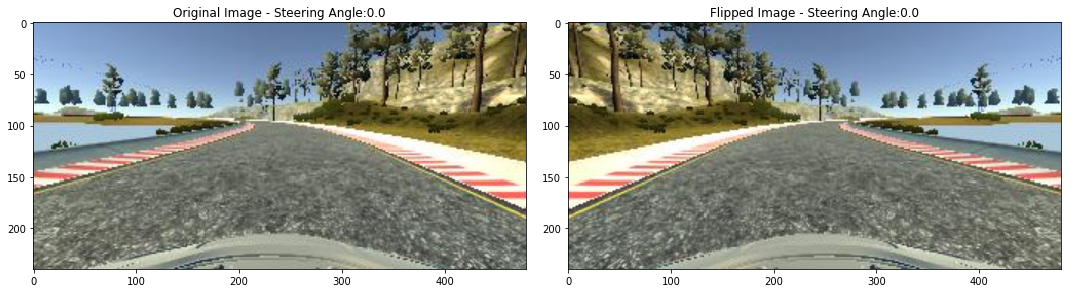

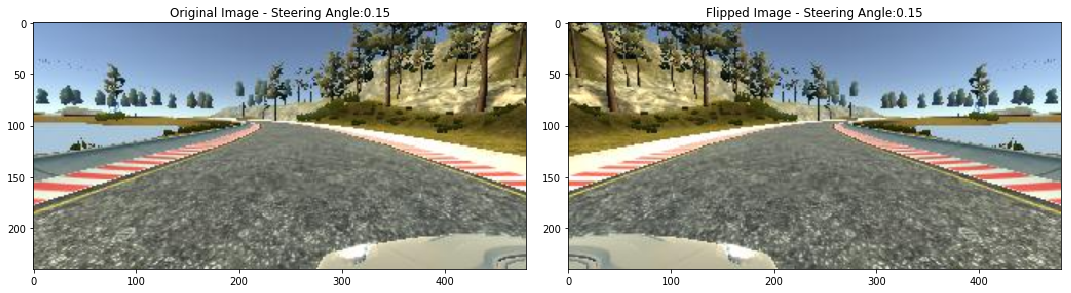

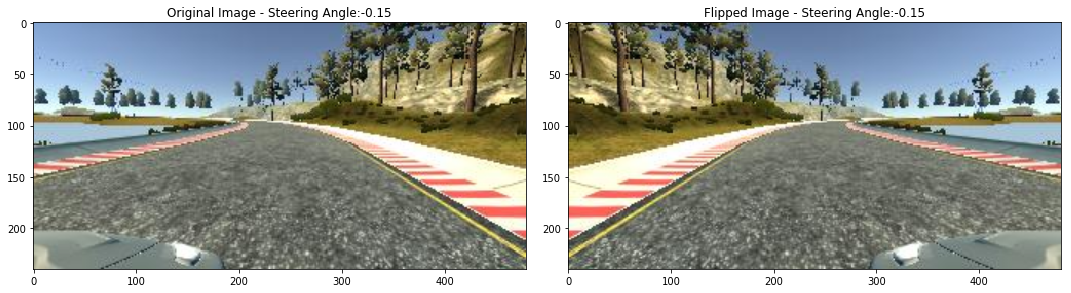

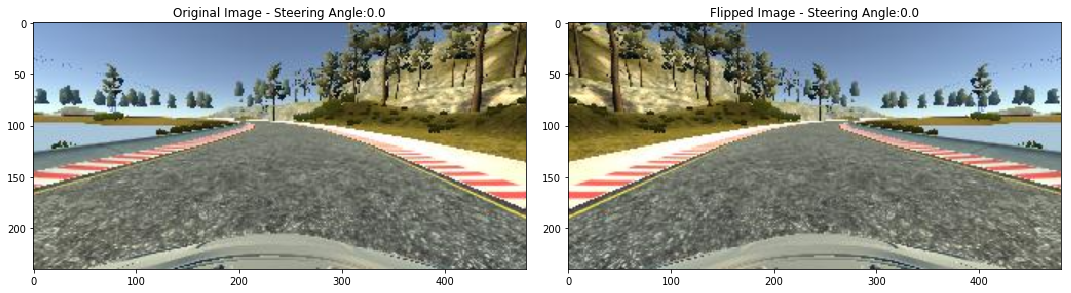

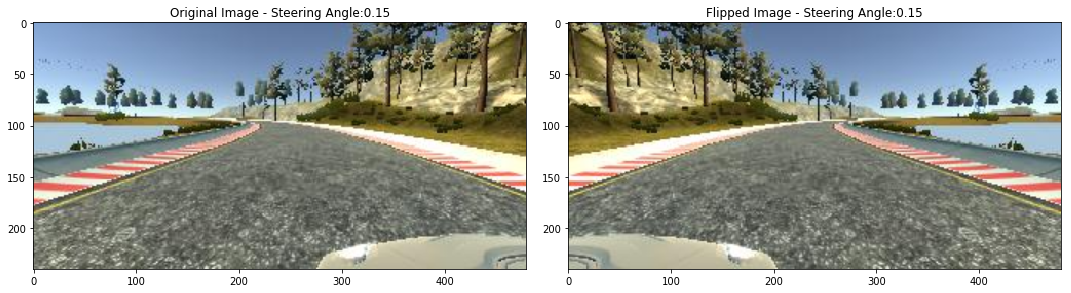

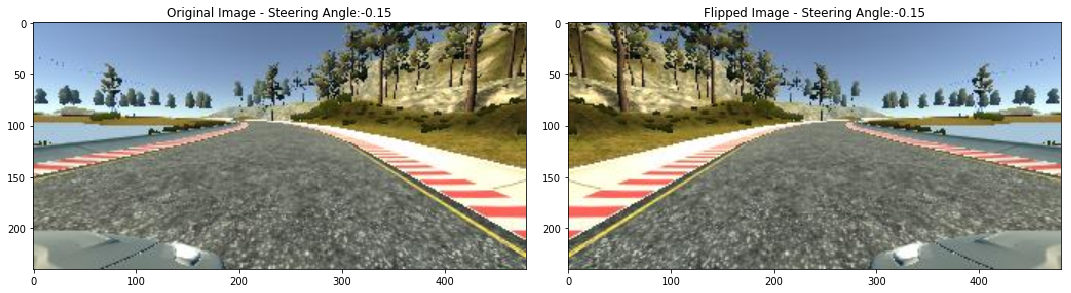

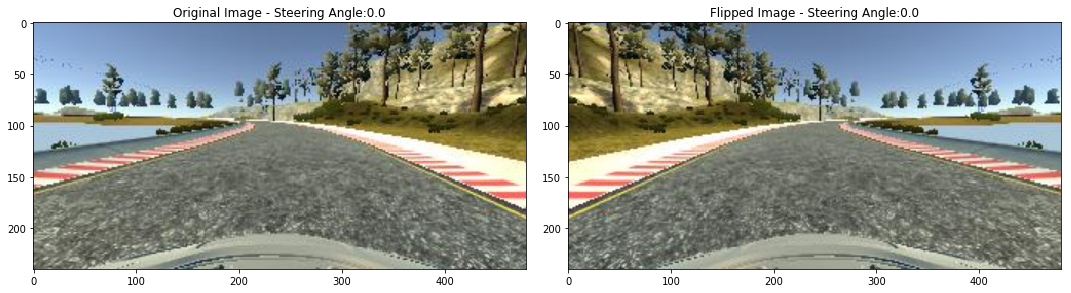

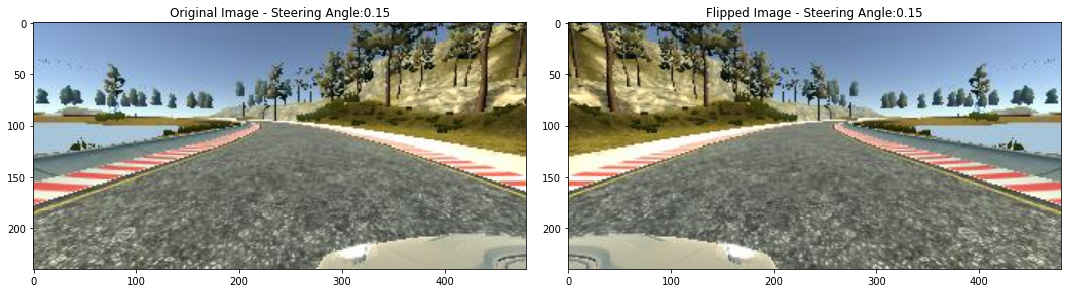

In [16]:
import sys
import csv
from tqdm import tqdm
import cv2
import datetime
import h5py
import numpy as np

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Conv2D, Cropping2D, Dropout, MaxPooling2D
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random


from models.resnet import resnet50_model


def getrowsFromDrivingLogs(dataPath):
    rows = []
    with open(dataPath + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)            
        for row in reader:
            rows.append(row)
    return rows

def getImageArray3angle(imagePath, steering, images, steerings):
    originalImage = cv2.imread(imagePath.strip())
    image = cv2.cvtColor(originalImage, cv2.COLOR_BGR2RGB)
    
    
    image = cv2.resize(image, dsize=(480,240)) # for resnet50
    
    
    images.append(image)
    steerings.append(steering)
    
def img_random_flip(image, steering):
    image = cv2.flip(image,1)
    steering = -steering
    return image, steering_angle
    
def getImagesAndSteerings(rows):
    
    images = []
    steerings = []
    
    for row in tqdm(rows):
            #angle
            steering = float(row[3])
            # 左右のカメラのステアリング測定値を調整します
            parameter = 0.15 
            # このパラメータが調整用の値です。
            # 左のカメラはステアリング角度が実際よりも低めに記録されているので、少し値を足してやります。右のカメラはその逆です。
            steering_left = steering + parameter
            steering_right = steering - parameter
 
            # データセットに画像とステアリング角度を加えます
            #center
            getImageArray3angle(row[0], steering, images, steerings)
            #left
            #images.append(cv2.imread(row[1].strip()))
            #steerings.append(steering_left)
            getImageArray3angle(row[1], steering_left, images, steerings)
            
            #right
            #images.append(cv2.imread(row[2].strip()))
            #steerings.append(steering_right)
            getImageArray3angle(row[2], steering_right, images, steerings)
        
    
    return (np.array(images), np.array(steerings))


def img_flip(image, steering):
    image = cv2.flip(image,1)
    steering = -steering
    return image, steering_angle

def trainModelAndSave(model, inputs, outputs, epochs, batch_size):
    
    X_train, X_valid, y_train, y_valid = train_test_split(inputs, outputs, test_size=0.2, shuffle=True)
    #Setting model
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=1.0e-4))
    #Learning model
    model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=epochs, verbose=1, validation_data=(X_valid, y_valid))
    #Saving model
    model.save('model.h5')
    
#NVIDIA
def nvidia_model():
    model = Sequential()
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160, 320, 3)))
    model.add(Conv2D(24,5,5, subsample=(2,2), activation='elu'))
    model.add(Conv2D(36,5,5, subsample=(2,2), activation='elu'))
    model.add(Conv2D(48,5,5, subsample=(2,2), activation='elu'))
    model.add(Conv2D(64,3,3, activation='elu'))
    model.add(Conv2D(64,3,3, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(100, activation='elu'))
    model.add(Dense(50, activation='elu'))
    model.add(Dense(10, activation='elu'))
    model.add(Dense(1))
    return model

if __name__ == "__main__":
    
    epochs = 1
    # epochs = 10

    #Make sure to set batch size within 40
    batch_size = 5
    # batch_size = 40

    is_dataset = True
    #is_dataset = False
    
    #When making "is_dataset" True, saving preprocessed datasets
    #When making "is_dataset" False, using preprocessed and saved datasets. Shortens time because preprocessing is not required.It must be preprocessed once.
    if is_dataset:
        print('get csv data from Drivinglog.csv')
        rows = getrowsFromDrivingLogs('data')
        print('preprocessing data...')
        inputs, outputs = getImagesAndSteerings(rows)
        flipped_images = []
        flipped_steering_angles = []
#         i=1
        for original_image, steering_angle in zip(inputs,outputs):
            flipped_image, flipped_steering_angle = img_flip(original_image, steering_angle)
            flipped_images.append(flipped_image)
            flipped_steering_angles.append(flipped_steering_angle)
#             i=i+1
# #             if(i<10):
# #                 fig, axs = plt.subplots(1, 2, figsize=(15, 10))
# #                 fig.tight_layout()
# #                 axs[0].imshow(original_image)
# #                 axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

# #                 axs[1].imshow(flipped_image)
# #                 axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))
        inputs = np.concatenate((flipped_images, inputs))
        outputs = np.concatenate((flipped_steering_angles, outputs))
        with h5py.File('./trainingData.h5', 'w') as f:
            f.create_dataset('inputs', data=inputs)
            f.create_dataset('outputs', data=outputs)
    
    else:
        with h5py.File('./trainingData.h5', 'r') as f:
            inputs = np.array(f['inputs'])
            outputs = np.array(f['outputs'])

    print('Training data:', inputs.shape)
    print('Training label:', outputs.shape)
    
    #Specifying model
    model = resnet50_model()
#     model = nvidia_model()
    
    
    
    #Training and saving model
    trainModelAndSave(model, inputs, outputs, epochs, batch_size)